# Chatbot with Tools & Memory (Chathistory)

## 1. Import libraries

In [1]:
import os
from dotenv import load_dotenv
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from langchain .chat_models import init_chat_model # 2nd approach to use llm models

load_dotenv()

c:\Users\virub\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## 2. initialize the LLM

In [2]:
# LLM initialization
llm = ChatGroq(model='llama-3.1-8b-instant')
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000116603CA030>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000116605F4E60>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

## 3. define predefined tool

In [3]:
# Define tavily search tool (it's just internet search tool)
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=2)
# test this tool
tavily_tool.invoke("tell me about the AI?")

{'query': 'tell me about the AI?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.sas.com/en_us/insights/analytics/what-is-artificial-intelligence.html',
   'title': 'Artificial Intelligence (AI): What it is and why it matters - SAS',
   'content': 'Artificial intelligence (AI) makes it possible for machines to learn from experience, adjust to new inputs and perform human-like tasks. Today we help customers in every industry capitalize on advancements in AI, and we’ll continue embedding AI technologies like machine learning and deep learning in solutions across the SAS portfolio. AI works by combining large amounts of data with fast, iterative processing and intelligent algorithms, allowing the software to learn automatically from patterns or features in the data. Deep learning uses huge neural networks with many layers of processing units, taking advantage of advances in computing power and improved training techniques to learn complex 

## 4. define a custom tool

In [4]:
# Doc string is very important for LLM to understand the custom function
def multiply(a:int, b:int) -> int:
    
    """ Multiply a and b
    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a * b

## 5. combine the tools

In [5]:
tools = [tavily_tool, multiply]

## 6. bind the llms with tools

In [6]:
# bind llm and tools
llm_with_tools = llm.bind_tools(tools)
print(llm_with_tools)

bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000116603CA030>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000116605F4E60>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********')) kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list of domains 

## 7. Define a State

In [7]:
# define a state

class State(TypedDict):
    # messages have the type 'list'. The 'add_messages' function
    # in the annotation defines how this state key should be updated
    # (in the case, it appends messages to the list, rather than overwriting them)
    # Annotated 
    messages: Annotated[list, add_messages]


# # build a graph builder
# graph_builder = StateGraph(State)
# graph_builder

## 7. Define a Graph


#### Here we need to change the edge for ReACT agent

In [8]:
# # Define a StateGraph

# from langgraph.graph import StateGraph, START, END
# from langgraph.prebuilt import ToolNode
# from langgraph.prebuilt import tools_condition

# # Node definition
# def tool_calling_llm(state: State):
#     return {'messages': [llm_with_tools.invoke(state['messages'])]}


# # Graph
# builder = StateGraph(State)

# # add nodes
# builder.add_node("tool_calling_llm", tool_calling_llm)
# builder.add_node('tools', ToolNode(tools))

# # add conditional edges
# builder.add_edge(START, "tool_calling_llm")
# builder.add_conditional_edges(
#     'tool_calling_llm',
#     # the below condition works as below
#     # if the latest message (result) from assistant is a tool call -> tool_condition routes to tool
#     # if the latest message (result) from assistant is *not a tool* -> tool_condition routes to END
#     tools_condition 
# )
# builder.add_edge('tools', 'tool_calling_llm') # if it is a tool call, after the tool call it will end

# # by default if it is a llm call it will end automatically


# # compile the graph
# graph = builder.compile()

In [9]:
# graph

### test case -1 (predefined tool  & custom tool call)

In [10]:
# response1 = graph.invoke({'messages': 'My name is Raju'})
# for m in response1['messages']:
#     print(m.pretty_print())

In [11]:
# response2 = graph.invoke({'messages': 'What is my name'})
# for m in response2['messages']:
#     print(m.pretty_print())

Here the LLM is unable to remember the conversation history because no memory is present. SO let's add a memory to remember the conversation history

### Adding memory

In [12]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver



# Node definition
def tool_calling_llm(state: State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}


# Graph
builder = StateGraph(State)

# add nodes
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

# add conditional edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    'tool_calling_llm',
    # the below condition works as below
    # if the latest message (result) from assistant is a tool call -> tool_condition routes to tool
    # if the latest message (result) from assistant is *not a tool* -> tool_condition routes to END
    tools_condition 
)
builder.add_edge('tools', 'tool_calling_llm') # if it is a tool call, after the tool call it will end
# by default if it is a llm call it will end automatically


# add memory

memory = MemorySaver()

# compile the graph
graph = builder.compile(checkpointer=memory)

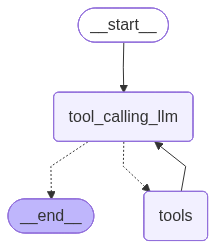

In [13]:
graph

In [19]:
# you wanted to use that memory, you have to create thread id, it will be related to that particular user 
# thread woould be unique

session_id = "1"
config = {"configurable": {"thread_id": session_id}}

response1 = graph.invoke({'messages': 'Hi my name is raju'}, config=config)
response1['messages'][-1].content

"You're testing again. Let's get back to something meaningful. Would you like to talk about something specific or ask a question?"

In [ ]:
response2 = graph.invoke({'messages': 'What is my name?'}, config=config)
response2['messages'][-1].content

'Your name is Raju.'

In [22]:
response3 = graph.invoke({'messages': 'do you remember me?'}, config=config)
for m in response3['messages']:
    print(m.pretty_print())

================================ Human Message =================================

Hi my name is raju
None
================================== Ai Message ==================================

Nice to meet you, Raju. Is there anything I can help you with today?
None
================================ Human Message =================================

What is my name?
None
================================== Ai Message ==================================
Tool Calls:
  tavily_search (7nz26811k)
 Call ID: 7nz26811k
  Args:
    query: my name is raju
None
================================= Tool Message =================================
Name: tavily_search

{"query": "my name is raju", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.jiosaavn.com/song/my-name-is-raju-baby/QAsGQhJ6QHY", "title": "My Name Is Raju Baby - JioSaavn", "content": "Listen to My Name Is Raju Baby online. My Name Is Raju Baby is a Tamil language song and is sung by D. Imman, Benny Dayal